# Comparando pipelines

Incluye:

- Comparación de modelos cantidatos
- Elección del modelo opt
- Comparación de modelo opt elegido según meses de entrenamiento

In [10]:
!pip install dask[dataframe]

In [ ]:
# Librerias
import os
import pandas as pd
import numpy as np

#######
# rutas
# datasets
from config import dataset_file_fe6_6xpqt,\
                   dataset_file_fe6_6xpqt_opt_under
# optimizacion
from config import db_path
# modelos
from config import modelos_path
# predicciones
from config import pred_path

##########
# pipeline
from processing import ModelPipeline, plot_comparisons_on_kaggle_split
from processing import analyze_study
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
import optuna
import warnings

# Ignorar advertencias de tipo UserWarning
warnings.filterwarnings('ignore', category=UserWarning, module='pandas')
warnings.filterwarnings('ignore', category=Warning, module='lightgbm')
warnings.filterwarnings('ignore', category=UserWarning, module='lightgbm')
warnings.filterwarnings('ignore', category=Warning, module='xgboost')
warnings.filterwarnings('ignore', category=UserWarning, module='xgboost')


Variables de train y test

In [12]:
ganancia_acierto = 273000
costo_estimulo = 7000

mes_train_all = [201901, 201902, 201903, 201904, 201905, 201906, 201907, 201908,
                 201909, 201910, 201911, 201912, 202001, 202002, 202003, 202004,
                 202005, 202006, 202007, 202008, 202009, 202010, 202011, 202012,
                 202101, 202102, 202103, 202104, 202105, 202106, 202107]

mes_train_ult_3_meses = [202105, 202106, 202107]

mes_train_ult_6_meses = [202102, 202103, 202104, 202105, 202106, 202107]

mes_train_ult_9_meses = [202010, 202011, 202012, 202101, 202102, 202103, 202104, 202105, 202106, 202107]

mes_train_ult_anio = [202007, 202008, 202009, 202010, 202011, 202012,
                 202101, 202102, 202103, 202104, 202105, 202106, 202107]

mes_train = [202107]
mes_test = 202109

threshold = 0.025

semillas = [437809, 327347, 392879, 455783, 217163]

## Modelos candidatos

Entrando CON / SIN undersampling

> lgbm prepro6 fe6 y 12 opt (local opt 10 % de CONTINUA)

> lgbm prepro6 fe6 y 12 opt (cloud opt 10 % de CONTINUA)

> lgbm semillerio de Denicolay

## Loading data con undersampling

Entrenamiento local con undersampling de 10 % de CONTINUA

In [ ]:
data = pd.read_parquet(dataset_file_fe6_6xpqt_opt_under)

# running local, con undersampling
# data = pd.read_parquet("datos/datasets_competencia_03_fe6x_opt_under.parquet")

# Mapear etiquetas de clase a números
label_mapping = {'CONTINUA': 0, 'BAJA+1': 1, 'BAJA+2': 2}

data['clase_ternaria'] = data['clase_ternaria'].map(label_mapping)

# Simulación para Kaggle
mes_bt_ult_anio = [202008, 202009, 202010, 202011, 202012,
                 202101, 202102, 202103, 202104, 202105]

X_train = data[data['foto_mes'].isin(mes_bt_ult_anio)]
y_train = X_train['clase_ternaria']
X_train = X_train.drop(columns=['clase_ternaria'])

mes_futuro = 202107 # usado como test
X_test = data[data['foto_mes'] == mes_futuro]
y_test = X_test['clase_ternaria']
X_test = X_test.drop(columns=['clase_ternaria'])

del data

Preprocesando data

In [14]:
# Imputacion de Xs
cols_with_all_nan = X_train.columns[X_train.isna().all()].tolist()
print("Columns with all NaN values:", cols_with_all_nan)
X_train = X_train.drop(columns=cols_with_all_nan)
X_test = X_test.drop(columns=cols_with_all_nan)

# Imputación de nulls
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
X_train_imp = pd.DataFrame(imp_median.fit_transform(X_train), columns=X_train.columns)
X_test_imp = pd.DataFrame(imp_median.transform(X_test), columns=X_train.columns)

del X_train
del X_test

# Codificar variables categóricas
categorical_features = [col for col in X_train_imp.columns if X_train_imp[col].dtype == 'object']

# Convertir variables categóricas a 'category' dtype para LightGBM
for col in categorical_features:
    X_train_imp[col] = X_train_imp[col].astype('category')
    X_test_imp[col] = X_test_imp[col].astype('category')

Columns with all NaN values: ['payroll_slope_1_foto_mes', 'cuenta_corriente_slope_1_foto_mes', 'visa_consumo_slope_1_foto_mes', 'comisiones_mantenimiento_slope_1_foto_mes', 'comisiones_otras_slope_1_foto_mes']


### lightgbm prepro6 fe6 y 12 opt (local opt under) 

**Prepro in 6 months Conceptual FE 6 months + Lag1 + Delta1**

comp03_prepro_6x.ipynb

comp03_fe6_6x.ipynb

**Usando los últimos 12 meses para optimizar** con 10 % de CONTINUA

comp03_pipeline_optx.ipynb

!SUBIR optimization_tree.db a gcp

### Corriendo pipeline con LightGBM ###

# Entrenando el modelo base LightGBM
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.381122 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86193
[LightGBM] [Info] Number of data points in the train set: 191922, number of used features: 659
[LightGBM] [Info] Start training from score -0.088123
[LightGBM] [Info] Start training from score -3.182660
[LightGBM] [Info] Start training from score -3.149425


[I 2024-11-28 14:58:20,156] Using an existing study with name 'exp_lgbm_comp03_v01' instead of creating a new one.



# Evaluando el modelo base en el conjunto de prueba
Ganancia del modelo en el conjunto de test: 290024000.0 por mes
Según un promedio de los 1 meses evaluados

# Optimizando el modelo
Mejores parámetros para lightgbm: {'n_estimators': 712, 'num_leaves': 26, 'learning_rate': 0.06228300247444606, 'min_data_in_leaf': 155, 'feature_fraction': 0.45138948206503426}

# Entrenando el mejor modelo con parámetros optimizados
[LightGBM] [Warning] min_data_in_leaf is set=155, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=155
[LightGBM] [Warning] feature_fraction is set=0.45138948206503426, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45138948206503426
[LightGBM] [Warning] min_data_in_leaf is set=155, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=155
[LightGBM] [Warning] feature_fraction is set=0.45138948206503426, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45138948206503426
[LightGBM] [Info] Au

c:\Users\santt\.conda\envs\dm_eyf\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


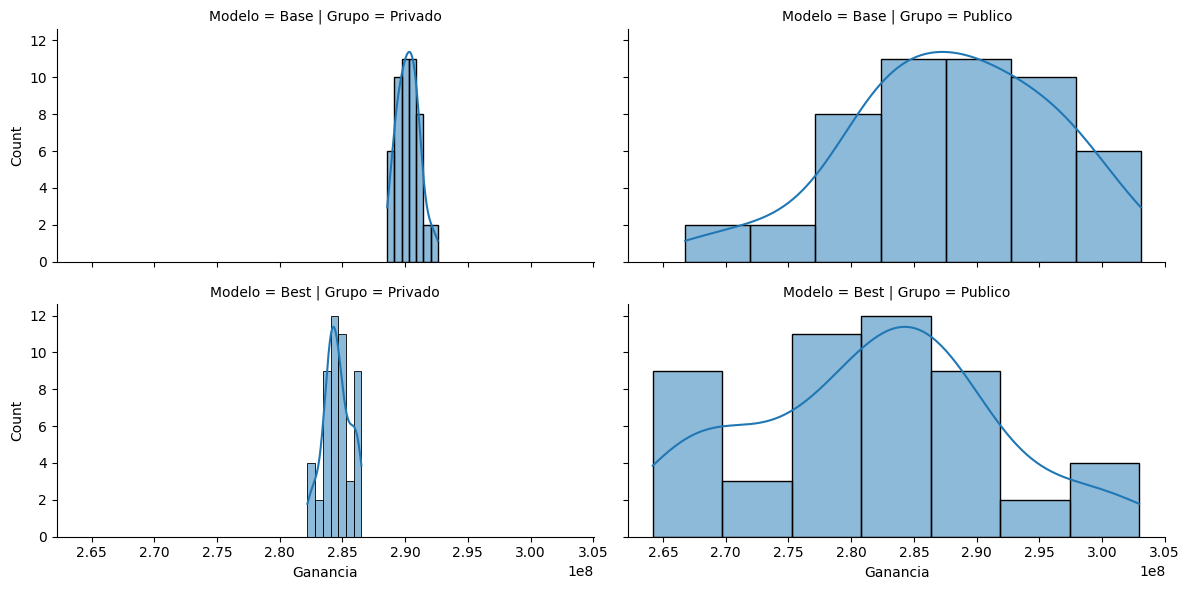

Ganancia media del modelo base en privado: 290253288.8888889
Ganancia media del modelo base en público: 287960400.0
Ganancia media del modelo Best en privado: 284574577.7777778
Ganancia media del modelo Best en público: 281668800.0


In [15]:
# Condiciones de la optimización
s = 1
prepro = 6 # data quality + data drifting
fe = 6 # feature engineering conceptual 6 meses
training = len(mes_bt_ult_anio)

print("### Corriendo pipeline con LightGBM ###")
# Inicializar el pipeline con 'lightgbm'
pipeline_lgbm_opt_under = ModelPipeline(data=None, seeds=semillas,
                                        model_type='lightgbm', seed=s, 
                                        meses_opt=training, meses_test=1,
                                        threshold=0.015, # según optx 
                                        n_jobs=-1)

print("\n# Entrenando el modelo base LightGBM")
pipeline_lgbm_opt_under.train_base_model(X_train_imp, y_train)

print("\n# Evaluando el modelo base en el conjunto de prueba")
pipeline_lgbm_opt_under.test_base_model(X_test_imp, y_test)

# Definir el almacenamiento para Optuna
storage_name = "sqlite:///" + db_path + "optimization_tree.db"
# carga local
# storage_name = "sqlite:///optimizacion/optimization_tree.db"
study_name = f"exp_lgbm_comp03_local_v00"

print("\n# Optimizando el modelo")
pipeline_lgbm_opt_under.optimize_model(
    X_train_imp, y_train,
    storage_name=storage_name,
    study_name=study_name,
    optimize=False,  
    n_trials=100
)

# Entrenar el mejor modelo con parámetros optimizados
print("\n# Entrenando el mejor modelo con parámetros optimizados")
pipeline_lgbm_opt_under.train_best_model(X_train_imp, y_train)

# Evaluar el mejor modelo en el conjunto de prueba
print("\n# Evaluando el mejor modelo en el conjunto de prueba")
pipeline_lgbm_opt_under.test_best_model(X_test_imp, y_test)

# Simular el split Kaggle y comparar modelos
print("\n# Simulando el split Kaggle y comparando modelos")

fpri_best_lgbm_opt_under, fpri_base_lgbm_opt_under, \
fpub_best_lgbm_opt_under, fpub_base_lgbm_opt_under = \
pipeline_lgbm_opt_under.simulate_kaggle_split(X_test_imp, y_test, test_size=0.1) # sin imputer ni to_drop porque estan prepro

> COMENTARIO:

Viendo estos resultados, en un back-testing para evaluar la optimización hecha, es notable que la mejora esperada no llega a apreciarse.

Una posible explicación se debe a que, durante la optimización, la semilla del lgbm no fue fijada para aumentar robustez en la optimización.

Más optimización podría ser una posible solución.

Exploring optimization

In [ ]:
study = analyze_study(storage_name, study_name)

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_param_importances(study)

In [ ]:
optuna.visualization.plot_slice(study)

Guardo resultados best para generar un registro reutilizable

In [ ]:
df_bt = pd.DataFrame({
    'pri_best_opt_under': fpri_best_lgbm_opt_under,
    'pub_best_opt_under': fpub_best_lgbm_opt_under,
})

### lightgbm prepro6 fe6 y 12 opt (cloud opt under) 

**Prepro in 6 months Conceptual FE 6 months + Lag1 + Delta1**

comp03_prepro_6x.ipynb

comp03_fe6_6x.ipynb

**Usando los últimos 12 meses para optimizar** con 10 % de CONTINUA

comp03_pipeline_optx.ipynb

In [ ]:
# Condiciones de la optimización
s = 1
prepro = 6 # data quality + data drifting
fe = 6 # feature engineering conceptual 6 meses
training = len(mes_bt_ult_anio)

print("### Corriendo pipeline con LightGBM ###")
# Inicializar el pipeline con 'lightgbm'
pipeline_lgbm_copt_under = ModelPipeline(data=None, seeds=semillas,
                                        model_type='lightgbm', seed=s, 
                                        meses_opt=training, meses_test=1,
                                        threshold=0.015, # según optx 
                                        n_jobs=-1)

print("\n# Entrenando el modelo base LightGBM")
pipeline_lgbm_copt_under.train_base_model(X_train_imp, y_train)

print("\n# Evaluando el modelo base en el conjunto de prueba")
pipeline_lgbm_copt_under.test_base_model(X_test_imp, y_test)

# Definir el almacenamiento para Optuna
storage_name = "sqlite:///" + db_path + "optimization_lgbm.db"
# carga local
# storage_name = "sqlite:///optimizacion/optimization_lgbm.db" 
study_name = f"exp_lgbm_comp03_cloud_v00"

print("\n# Optimizando el modelo")
pipeline_lgbm_copt_under.optimize_model(
    X_train_imp, y_train,
    storage_name=storage_name,
    study_name=study_name,
    optimize=False,  
    n_trials=100
)

# Entrenar el mejor modelo con parámetros optimizados
print("\n# Entrenando el mejor modelo con parámetros optimizados")
pipeline_lgbm_copt_under.train_best_model(X_train_imp, y_train)

# Evaluar el mejor modelo en el conjunto de prueba
print("\n# Evaluando el mejor modelo en el conjunto de prueba")
pipeline_lgbm_copt_under.test_best_model(X_test_imp, y_test)

# Simular el split Kaggle y comparar modelos
print("\n# Simulando el split Kaggle y comparando modelos")

fpri_best_lgbm_gcp_opt_under, fpri_base_lgbm_gcp_opt_under, \
fpub_best_lgbm_gcp_opt_under, fpub_base_lgbm_gcp_opt_under = \
pipeline_lgbm_copt_under.simulate_kaggle_split(X_test_imp, y_test, test_size=0.1) # sin imputer ni to_drop porque estan prepro

Exploring optimization

In [ ]:
study = analyze_study(storage_name, study_name)

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_param_importances(study)

In [ ]:
optuna.visualization.plot_slice(study)

In [ ]:
df_bt['pri_best_copt_under'] = fpri_best_lgbm_gcp_opt_under
df_bt['pub_best_copt_under'] = fpub_best_lgbm_gcp_opt_under

### lgbm semillerio de Denicolay

**Prepro in 6 months Conceptual FE 6 months + Lag1 + Delta1**

comp03_prepro_6x.ipynb

comp03_fe6_6x.ipynb

Con parámetros según modelos semillerio de Denicolay


### Corriendo pipeline con LightGBM ###

# Entrenando el modelo base
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.332453 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86193
[LightGBM] [Info] Number of data points in the train set: 191922, number of used features: 659
[LightGBM] [Info] Start training from score -0.088123
[LightGBM] [Info] Start training from score -3.182660
[LightGBM] [Info] Start training from score -3.149425

# Evaluando el modelo base en el conjunto de prueba
Ganancia del modelo en el conjunto de test: 290024000.0 por mes
Según un promedio de los 1 meses evaluados

# Entrenando el mejor modelo con parámetros optimizados
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [

c:\Users\santt\.conda\envs\dm_eyf\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


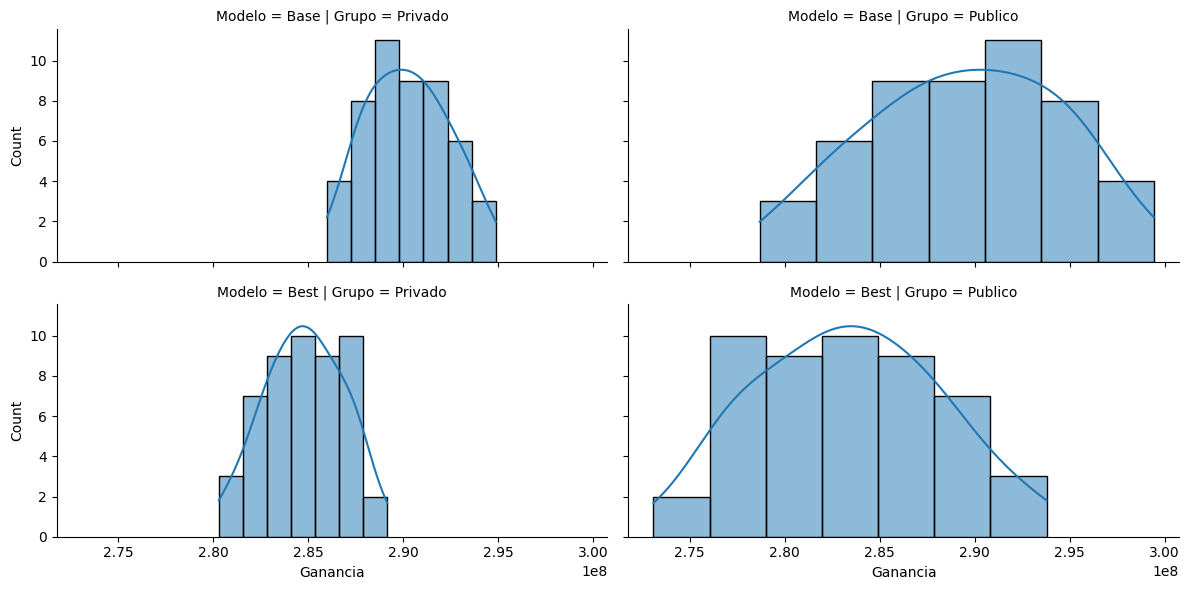

Ganancia media del modelo base en privado: 290260800.0
Ganancia media del modelo base en público: 289471466.66666675
Ganancia media del modelo Best en privado: 284791200.0
Ganancia media del modelo Best en público: 283310533.3333334


In [20]:
# Condiciones de la optimización
s = 1
training = len(mes_bt_ult_anio)

print("### Corriendo pipeline con LightGBM ###")
# Inicializar el pipeline con 'lightgbm'
pipeline_sem = ModelPipeline(data=None, seeds=semillas,
                             model_type='lightgbm', seed=s, 
                             meses_opt=training, meses_test=1,
                             threshold=0.015, # según optx 
                             n_jobs=-1)

semillerio_params = {'n_estimators': 23,
                  'num_leaves': 32,
                  'learning_rate': 0.34,
                  'min_data_in_leaf': 711,
                  'feature_fraction': 0.2,
                  'extra_trees': False,
                  'random_state': semillas[s],
}

pipeline_sem.best_params = semillerio_params

print("\n# Entrenando el modelo base")
pipeline_sem.train_base_model(X_train_imp, y_train)

print("\n# Evaluando el modelo base en el conjunto de prueba")
pipeline_sem.test_base_model(X_test_imp, y_test)

# Entrenar el mejor modelo con parámetros optimizados
print("\n# Entrenando el mejor modelo con parámetros optimizados")
pipeline_sem.train_best_model(X_train_imp, y_train)

# Evaluar el mejor modelo en el conjunto de prueba
print("\n# Evaluando el mejor modelo en el conjunto de prueba")
pipeline_sem.test_best_model(X_test_imp, y_test)

# Simular el split Kaggle y comparar modelos
print("\n# Simulando el split Kaggle y comparando modelos")

fpri_best_lgbm_sem_under, fpri_base_lgbm_sem_under, \
fpub_best_lgbm_sem_under, fpub_base_lgbm_sem_under = \
pipeline_sem.simulate_kaggle_split(X_test_imp, y_test) 

del X_train_imp
del X_test_imp

Agrego resultados best para generar un registro reutilizable

In [ ]:
df_bt['pri_best_sem_under'] = fpri_best_lgbm_sem_under
df_bt['pub_best_sem_under'] = fpub_best_lgbm_sem_under

## Loading data sin undersampling

Solo ejecutable en la nube

In [ ]:
data = pd.read_parquet(dataset_file_fe6_6xpqt)

# Mapear etiquetas de clase a números
label_mapping = {'CONTINUA': 0, 'BAJA+1': 1, 'BAJA+2': 2}

data['clase_ternaria'] = data['clase_ternaria'].map(label_mapping)

# Simulación para Kaggle
mes_bt_ult_anio = [202008, 202009, 202010, 202011, 202012,
                 202101, 202102, 202103, 202104, 202105]

X_train = data[data['foto_mes'].isin(mes_bt_ult_anio)]
y_train = X_train['clase_ternaria']
X_train = X_train.drop(columns=['clase_ternaria'])

mes_futuro = 202107 # usado como test
X_test = data[data['foto_mes'] == mes_futuro]
y_test = X_test['clase_ternaria']
X_test = X_test.drop(columns=['clase_ternaria'])

del data

Preprocesando data

In [ ]:
# Imputacion de Xs
cols_with_all_nan = X_train.columns[X_train.isna().all()].tolist()
print("Columns with all NaN values:", cols_with_all_nan)
X_train = X_train.drop(columns=cols_with_all_nan)
X_test = X_test.drop(columns=cols_with_all_nan)

# Imputación de nulls
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
X_train_imp = pd.DataFrame(imp_median.fit_transform(X_train), columns=X_train.columns)
X_test_imp = pd.DataFrame(imp_median.transform(X_test), columns=X_train.columns)

del X_train
del X_test

# Codificar variables categóricas
categorical_features = [col for col in X_train_imp.columns if X_train_imp[col].dtype == 'object']

# Convertir variables categóricas a 'category' dtype para LightGBM
for col in categorical_features:
    X_train_imp[col] = X_train_imp[col].astype('category')
    X_test_imp[col] = X_test_imp[col].astype('category')

### lightgbm prepro6 fe6 y 12 opt (local opt under) 

**Prepro in 6 months Conceptual FE 6 months + Lag1 + Delta1**

comp03_prepro_6x.ipynb

comp03_fe6_6x.ipynb

**Usando los últimos 12 meses para optimizar** con 10 % de CONTINUA

comp03_pipeline_optx.ipynb

!SUBIR optimization_tree.db a gcp

In [ ]:
# Condiciones de la optimización
s = 1
prepro = 6 # data quality + data drifting
fe = 6 # feature engineering conceptual 6 meses
training = len(mes_bt_ult_anio)

print("### Corriendo pipeline con LightGBM ###")
# Inicializar el pipeline con 'lightgbm'
pipeline_lgbm_opt_under = ModelPipeline(data=None, seeds=semillas,
                                        model_type='lightgbm', seed=s, 
                                        meses_opt=training, meses_test=1,
                                        threshold=0.015, # según optx 
                                        n_jobs=-1)

print("\n# Entrenando el modelo base LightGBM")
pipeline_lgbm_opt_under.train_base_model(X_train_imp, y_train)

print("\n# Evaluando el modelo base en el conjunto de prueba")
pipeline_lgbm_opt_under.test_base_model(X_test_imp, y_test)

# Definir el almacenamiento para Optuna
storage_name = "sqlite:///" + db_path + "optimization_tree.db"
# carga local
# storage_name = "sqlite:///optimizacion/optimization_tree.db"
study_name = f"exp_lgbm_comp03_local_v00"

print("\n# Optimizando el modelo")
pipeline_lgbm_opt_under.optimize_model(
    X_train_imp, y_train,
    storage_name=storage_name,
    study_name=study_name,
    optimize=False,  
    n_trials=100
)

# Entrenar el mejor modelo con parámetros optimizados
print("\n# Entrenando el mejor modelo con parámetros optimizados")
pipeline_lgbm_opt_under.train_best_model(X_train_imp, y_train)

# Evaluar el mejor modelo en el conjunto de prueba
print("\n# Evaluando el mejor modelo en el conjunto de prueba")
pipeline_lgbm_opt_under.test_best_model(X_test_imp, y_test)

# Simular el split Kaggle y comparar modelos
print("\n# Simulando el split Kaggle y comparando modelos")

fpri_best_lgbm_opt, fpri_base_lgbm_opt, \
fpub_best_lgbm_opt, fpub_base_lgbm_opt = \
pipeline_lgbm_opt_under.simulate_kaggle_split(X_test_imp, y_test, test_size=0.1) # sin imputer ni to_drop porque estan prepro

Guardo resultados best para generar un registro reutilizable

In [ ]:
df_bt['pri_best_opt'] = fpri_best_lgbm_opt
df_bt['pub_best_opt'] = fpub_best_lgbm_opt

### lightgbm prepro6 fe6 y 12 opt (cloud opt under) 

**Prepro in 6 months Conceptual FE 6 months + Lag1 + Delta1**

comp03_prepro_6x.ipynb

comp03_fe6_6x.ipynb

**Usando los últimos 12 meses para optimizar** con 10 % de CONTINUA

comp03_pipeline_optx.ipynb

In [ ]:
# Condiciones de la optimización
s = 1
prepro = 6 # data quality + data drifting
fe = 6 # feature engineering conceptual 6 meses
training = len(mes_bt_ult_anio)

print("### Corriendo pipeline con LightGBM ###")
# Inicializar el pipeline con 'lightgbm'
pipeline_lgbm_opt_under = ModelPipeline(data=None, seeds=semillas,
                                        model_type='lightgbm', seed=s, 
                                        meses_opt=training, meses_test=1,
                                        threshold=0.015, # según optx 
                                        n_jobs=-1)

print("\n# Entrenando el modelo base LightGBM")
pipeline_lgbm_opt_under.train_base_model(X_train_imp, y_train)

print("\n# Evaluando el modelo base en el conjunto de prueba")
pipeline_lgbm_opt_under.test_base_model(X_test_imp, y_test)

# Definir el almacenamiento para Optuna
storage_name = "sqlite:///" + db_path + "optimization_lgbm.db"
# carga local
# storage_name = "sqlite:///optimizacion/optimization_lgbm.db"
study_name = f"exp_lgbm_comp03_cloud_v00"

print("\n# Optimizando el modelo")
pipeline_lgbm_opt_under.optimize_model(
    X_train_imp, y_train,
    storage_name=storage_name,
    study_name=study_name,
    optimize=False,  
    n_trials=100
)

# Entrenar el mejor modelo con parámetros optimizados
print("\n# Entrenando el mejor modelo con parámetros optimizados")
pipeline_lgbm_opt_under.train_best_model(X_train_imp, y_train)

# Evaluar el mejor modelo en el conjunto de prueba
print("\n# Evaluando el mejor modelo en el conjunto de prueba")
pipeline_lgbm_opt_under.test_best_model(X_test_imp, y_test)

# Simular el split Kaggle y comparar modelos
print("\n# Simulando el split Kaggle y comparando modelos")

fpri_best_lgbm_gcp_opt, fpri_base_lgbm_gcp_opt, \
fpub_best_lgbm_gcp_opt, fpub_base_lgbm_gcp_opt = \
pipeline_lgbm_opt_under.simulate_kaggle_split(X_test_imp, y_test, test_size=0.1) # sin imputer ni to_drop porque estan prepro

In [ ]:
df_bt['pri_best_copt'] = fpri_best_lgbm_gcp_opt
df_bt['pub_best_copt'] = fpub_best_lgbm_gcp_opt

### lgbm semillerio de Denicolay

**Prepro in 6 months Conceptual FE 6 months + Lag1 + Delta1**

comp03_prepro_6x.ipynb

comp03_fe6_6x.ipynb

Con parámetros según modelos semillerio de Denicolay

In [ ]:
# Condiciones de la optimización
s = 1
training = len(mes_bt_ult_anio)

print("### Corriendo pipeline con LightGBM ###")
# Inicializar el pipeline con 'lightgbm'
pipeline_sem = ModelPipeline(data=None, seeds=semillas,
                             model_type='lightgbm', seed=s, 
                             meses_opt=training, meses_test=1,
                             threshold=0.015, # según optx 
                             n_jobs=-1)

semillerio_params = {'n_estimators': 23,
                  'num_leaves': 32,
                  'learning_rate': 0.34,
                  'min_data_in_leaf': 711,
                  'feature_fraction': 0.2,
                  'extra_trees': False,
                  'random_state': semillas[s],
}

pipeline_sem.best_params = semillerio_params

print("\n# Entrenando el modelo base")
pipeline_sem.train_base_model(X_train_imp, y_train)

print("\n# Evaluando el modelo base en el conjunto de prueba")
pipeline_sem.test_base_model(X_test_imp, y_test)

# Entrenar el mejor modelo con parámetros optimizados
print("\n# Entrenando el mejor modelo con parámetros optimizados")
pipeline_sem.train_best_model(X_train_imp, y_train)

# Evaluar el mejor modelo en el conjunto de prueba
print("\n# Evaluando el mejor modelo en el conjunto de prueba")
pipeline_sem.test_best_model(X_test_imp, y_test)

# Simular el split Kaggle y comparar modelos
print("\n# Simulando el split Kaggle y comparando modelos")

fpri_best_lgbm_sem_under, fpri_base_lgbm_sem_under, \
fpub_best_lgbm_sem_under, fpub_base_lgbm_sem_under = \
pipeline_sem.simulate_kaggle_split(X_test_imp, y_test) 

del X_train_imp
del X_test_imp

In [ ]:
df_bt['pri_best_sem'] = fpri_best_lgbm_sem_under
df_bt['pub_best_sem'] = fpub_best_lgbm_sem_under

df_bt.to_csv(db_path+'pipeline_comp_bt.csv')

# local
# df_backtesting.to_csv('optimizacion/pipeline_comp_bt.csv')

Agrego resultados best para generar un registro reutilizable

## Elección del modelo optimizado

Distintos pipelines en sus pruebas de backtesting

In [ ]:
# df_bt = pd.read_csv(db_path+'pipeline_comp_bt.csv')
df_bt.head()

Comparando modelos: lgbm prepro6 fe6 y 3 opt (local opt)  vs. xgb prepro6 fe6 y 3 opt (local opt)


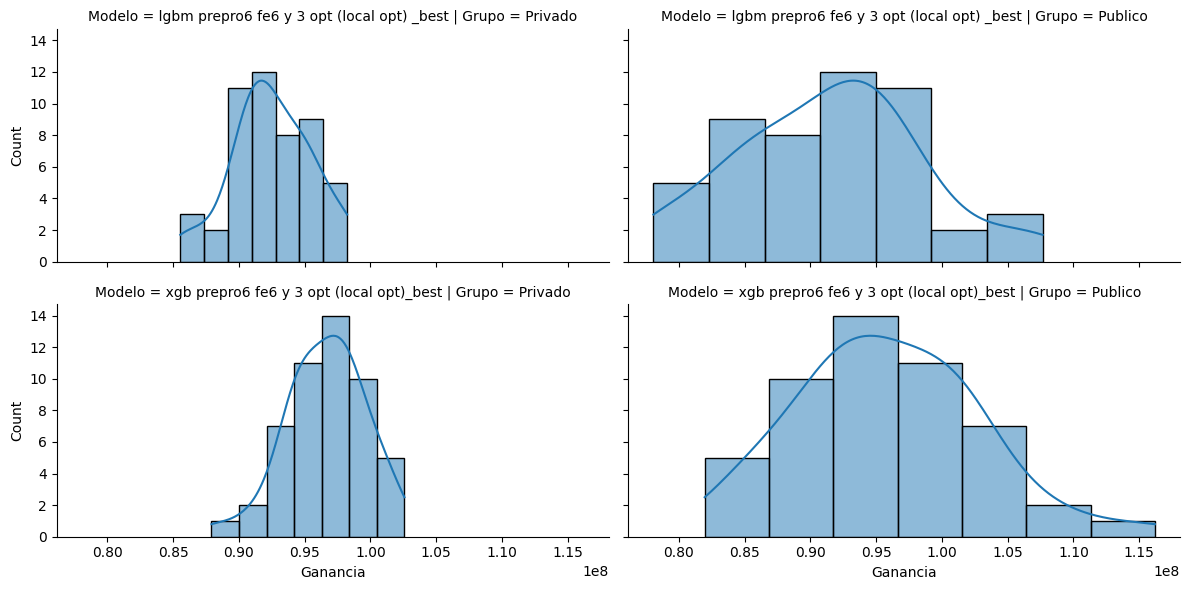

Ganancia media del modelo lgbm prepro6 fe6 y 3 opt (local opt)  privado: 92508000.0
Ganancia media del modelo lgbm prepro6 fe6 y 3 opt (local opt)  publico: 91424666.66666669
Ganancia media del modelo xgb prepro6 fe6 y 3 opt (local opt) privado: 96609800.0
Ganancia media del modelo xgb prepro6 fe6 y 3 opt (local opt) publico: 95923800.00000001

Resultado del test estadístico Mann-Whitney U (privado):
Estadístico U = 415.5
P-valor = 4.474539994580602e-09
Rechazamos la hipótesis nula. Hay evidencia estadística de que la distribución de xgb prepro6 fe6 y 3 opt (local opt)_priv es mayor que la de lgbm prepro6 fe6 y 3 opt (local opt) _priv.

Resultado del test estadístico Mann-Whitney U (privado):
Estadístico U = 823.5
P-valor = 0.0016578876183399318
Rechazamos la hipótesis nula. Hay evidencia estadística de que la distribución de xgb prepro6 fe6 y 3 opt (local opt)_pub es mayor que la de lgbm prepro6 fe6 y 3 opt (local opt) _pub.


In [ ]:
model_a = "lgbm local opt under"
model_b = "lgbm cloud opt under"

plot_comparisons_on_kaggle_split(model_a, df_bt.pri_best_opt_under.values, df_bt.pub_best_opt_under.values,
                                model_b, df_bt.pri_best_copt_under.values, df_bt.pub_best_copt_under.values)

In [ ]:
model_a = "lgbm local opt"
model_b = "lgbm cloud opt"

plot_comparisons_on_kaggle_split(model_a, df_bt.pri_best_opt.values, df_bt.pub_best_opt.values,
                                model_b, df_bt.pri_best_copt.values, df_bt.pub_best_copt.values)

In [ ]:
model_a = "lgbm sem under"
model_b = "lgbm sem"

plot_comparisons_on_kaggle_split(model_a, df_bt.pri_best_sem_under.values, df_bt.pub_best_sem_under.values,
                                model_b, df_bt.pri_best_sem.values, df_bt.pub_best_sem.values)

___